In [2]:
cmdstan_c_path = '/Users/choibaroti/opt/anaconda3/envs/cmdstan/lib/python3.9/site-packages/cmdstanpy/cmdstan-2.23.0'
from cmdstanpy import cmdstan_path, set_cmdstan_path
set_cmdstan_path(cmdstan_c_path)

import os
import sys
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel, cmdstan_path
import pickle
import json
from scipy.interpolate import splev
from sklearn.metrics import mean_squared_error
# from aria.utils.evaluation import smape
from sklearn.preprocessing import PowerTransformer, StandardScaler
import arviz as az
# import pystan

<AxesSubplot:xlabel='age', ylabel='basis'>

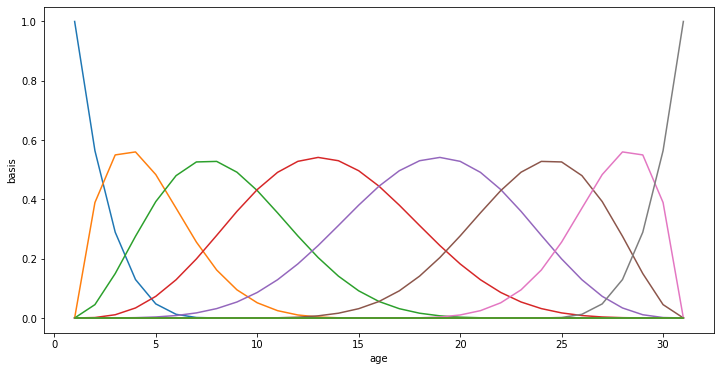

In [3]:
# knot 수에 따라 Bspline 파일 변

degree = 4
knots = np.linspace(1, 31, num=5)
knots_padded = np.concatenate((np.full(degree, 1), knots, np.full(degree, 31)))

basis = []
for i in range(knots_padded.shape[0]):
    c = np.zeros(knots_padded.shape[0])
    c[i] = 1
    basis.append(splev(np.arange(1, 32), (knots_padded, c, degree)))
basis_df = pd.DataFrame(basis).transpose().set_index(np.arange(1, 32))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('basis')
basis_df.plot(ax=ax, legend=False)

In [ ]:
basis_df.shape

In [ ]:
tx = pd.read_csv("data/y_count_original.csv")
tx.drop(columns="age", inplace=True)
pd.Series(tx.values[~np.isnan(tx)]).plot.kde()

In [ ]:
# transformer = StandardScaler()#PowerTransformer()
transformer = PowerTransformer()

y_data_raw = pd.read_csv("data/y_count_original.csv")
y_data_raw.drop(columns="age", inplace=True)
transformer.fit(y_data_raw.values[~np.isnan(y_data_raw)].reshape(-1, 1))
pd.Series(transformer.transform(y_data_raw.values[~np.isnan(y_data_raw)].reshape(-1, 1)).flatten()).plot.kde()
y_data = pd.DataFrame({"y":transformer.transform(y_data_raw.values[~np.isnan(y_data_raw)].reshape(-1, 1)).flatten()})

In [104]:
y_data = pd.read_csv(os.path.realpath("data/y_count_pwr.csv"), usecols=["y"])
age_data = pd.read_csv(os.path.realpath("data/x_age.csv"), usecols=["age"])
ship_data = pd.read_csv(os.path.realpath("data/ship_index.csv"), usecols=["ship"])
ship_engine_mapping_data = pd.read_csv(os.path.realpath("data/engine_type1to5.csv"), usecols=["engine"])
engine_data = pd.DataFrame({"engine": np.zeros(y_data.shape[0], dtype=np.int32)})
#shipsize_data = pd.DataFrame({"shipsize": np.zeros(y_data.shape[0], dtype=np.int32)})
#ship_size_mapping_data = pd.read_csv(os.path.realpath("../data/shipsize_index.csv"), usecols=["shipsize"])
for x in range(y_data.shape[0]):
    engine_data.at[x, "engine"] = ship_engine_mapping_data.at[ship_data.at[x, "ship"]-1, "engine"]
    #shipsize_data.at[x, "shipsize"] = ship_size_mapping_data.at[ship_data.at[x, "ship"]-1, "shipsize"]


## data matching부터

In [103]:
for x in range(y_data.shape[0]):
    print(ship_data.at[x, "ship"]-1)

0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
4
4
4
4
5
5
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
13
13
13
14
14
14
14
14
14
14
14
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
24
24
24
24
24
24
24
25
25
25
25
25
25
25
25
25
26
26
26
26
26
26
26
26
26
26
26
27
27
27
27
27
27
27
27
27
27
28
28
28
28
28
28
28
28
28
28
28
29
29
29
29
29
30
30
30
30
30
30
30
30
30
30
30
30
31
31
31
31
31
31
31
31
31
32
32
32
32
32
32
32
32
32
33
33
33
33
33
33
34
34
34
34
34
34
35
35
35
35
35
36
36
36
36
36
36
36
36
36
37
37
37
37
37
37
38
38
38
38
38
38
39
39
39
39
39
39
40
40
40
40
40
40
41
41
41
41
41
41
41
41
41
41
42
42
42
42
42
42
43
43
43
43
43
43
43
43
43
44
44
44
44
44
44
45
45
45
45
45
45
45
45
46
46
46
46
46
46
46
47
47
47


In [102]:
y_data = pd.DataFrame(pd.read_csv(os.path.realpath("data/2data.csv"), usecols=["y"]).y)
age_data = pd.DataFrame(pd.read_csv(os.path.realpath("data/2data.csv"), usecols=["age"]).age)
ship_data = pd.DataFrame(pd.read_csv(os.path.realpath("data/2data.csv"), usecols=["ship"]).ship)
ship_engine_mapping_data = pd.read_csv(os.path.realpath("data/2engine_type1to5.csv"), usecols=["engine"])
engine_data = pd.DataFrame({"engine": np.zeros(y_data.shape[0], dtype=np.int32)})
for x in range(y_data.shape[0]):
    engine_data.at[x, "engine"] = ship_engine_mapping_data.at[ship_data.at[x, "ship"]-1, "engine"]

KeyError: 92

In [81]:
failure_df = pd.read_csv(os.path.realpath('data/failure_count2.csv')).set_index('age')
u = np.nanmean(failure_df.iloc[:,1:].values.flatten())
s = np.sqrt(np.nanvar(failure_df.iloc[:,1:].values.flatten()))
failure_df = pd.DataFrame((failure_df - u) / s, index=failure_df.index, columns=failure_df.columns)
engine_df = pd.read_csv(os.path.realpath('data/engine2.csv')).set_index('ship')

test_failure_df = pd.read_csv(os.path.realpath('data/failure_count_test.csv')).set_index('age')
test_failure_df = pd.DataFrame((test_failure_df - u) / s, index=test_failure_df.index, columns=test_failure_df.columns)
test_engine_df = pd.read_csv(os.path.realpath('data/engine_test.csv')).set_index('ship')


y_data = failure_df.values[~failure_df.isnull()]
data_count = y_data.shape[0]
# # power transform
# pt = PowerTransformer()
# pt.fit(failure_df)
# failure_df = pd.DataFrame(pt.transform(failure_df),index=failure_df.index, columns=failure_df.columns)
# pt.fit(test_failure_df)
# test_failure_df = pd.DataFrame(pt.transform(test_failure_df), index=test_failure_df.index, columns=test_failure_df.columns)

In [ ]:
engine_model_data = {
    "K" : basis_df.shape[1],
    "N" : data_count,  # number of total values
    "T" : 31,  # length of time of data(31)
    "S" : 99, #ship_count, #failure_df.shape[1],  # number of ships(99)
    "E" : 5,  # number of unique engines
    "age": age_data["age"].values.tolist(),
    "engine": ship_engine_mapping_data["engine"].values.tolist(),  # engine type mapping
    "ship": ship_data["ship"].values.tolist(),#[int(i) for i in np.where(~np.isnan(failure_df).transpose())[0] + 1],  # ship type mapping
    "Y": y_data["y"].values.tolist(),#failure_df.values[~np.isnan(failure_df)].tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": data_count,
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [161]:
engine_count = int(np.max(engine_data["engine"]))
ship_count = int(np.max(ship_data["ship"]))
max_age = int(np.max(age_data["age"]))
data_count = y_data.shape[0]
# shipsize_count = int(np.max(shipsize_data["shipsize"]))
# print(engine_count, shipsize_count, ship_count, max_age, data_count)
# print(engine_data.shape, shipsize_data.shape, ship_data.shape, age_data.shape, y_data.shape)

In [106]:
pd.options.display.max_columns = None
y_data_raw

NameError: name 'y_data_raw' is not defined

In [107]:
np.mean(y_data), np.std(y_data)

(y    1.088121e-17
 dtype: float64,
 y    1.0
 dtype: float64)

In [108]:
np.sum(abs(y_data) > np.std(y_data) * 2)

y    31
dtype: int64

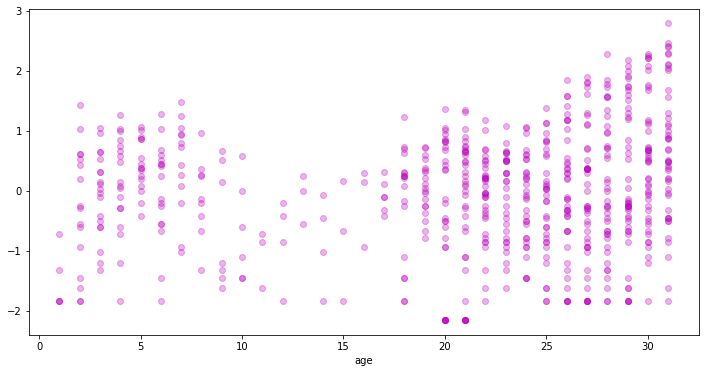

In [109]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.scatter(age_data, y_data["y"], color='m', alpha=0.3)


<AxesSubplot:ylabel='Density'>

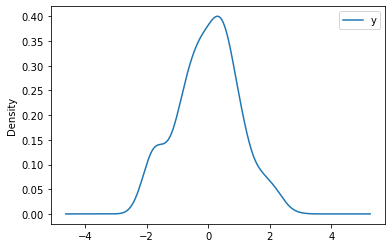

In [110]:
y_data.plot.kde()

# Model 1. Use engine type for data "engine"

In [111]:
model_file = os.path.join('models/layer3_nc_diffsd_parammubar.stan')
engine_model = CmdStanModel(stan_file = model_file)#, compile_model(layer3_path))

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/0f/92b3v9z5039728wtzhtnf44m0000gn/T/tmpzie3r1vg/tmpeuifta75
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/choibaroti/Desktop/Paper/200301 Failure Function/수정/수정2021/failure funtion code/models/layer3_nc_diffsd_parammubar


In [112]:
engine_model_data = {
    "K" : basis_df.shape[1],
    "N" : data_count,  # number of total values
    "T" : max_age,  # length of time of data(31)
    "S" : 99, #ship_count, #failure_df.shape[1],  # number of ships(99)
    "E" : engine_count,  # number of unique engines
    "age": age_data["age"].values.tolist(),
    "engine": ship_engine_mapping_data["engine"].values.tolist(),  # engine type mapping
    "ship": ship_data["ship"].values.tolist(),#[int(i) for i in np.where(~np.isnan(failure_df).transpose())[0] + 1],  # ship type mapping
    "Y": y_data["y"].values.tolist(),#failure_df.values[~np.isnan(failure_df)].tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": data_count,
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [119]:
%%time
engine_model_fit = engine_model.sample(chains=8, data=engine_model_data, adapt_delta=0.999, max_treedepth = 50)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 5
INFO:cmdstanpy:start chain 6
INFO:cmdstanpy:start chain 7
INFO:cmdstanpy:start chain 8
INFO:cmdstanpy:finish chain 8
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 5
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 6
INFO:cmdstanpy:finish chain 7
INFO:cmdstanpy:finish chain 4


CPU times: user 1.77 s, sys: 140 ms, total: 1.91 s
Wall time: 6min 28s


In [114]:
engine_model_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /var/folders/0f/92b3v9z5039728wtzhtnf44m0000gn/T/tmpnpjr1an5/layer3_nc_diffsd_parammubar-202102180837-1-qdixmqud.csv, /var/folders/0f/92b3v9z5039728wtzhtnf44m0000gn/T/tmpnpjr1an5/layer3_nc_diffsd_parammubar-202102180837-2-9qxaswcq.csv, /var/folders/0f/92b3v9z5039728wtzhtnf44m0000gn/T/tmpnpjr1an5/layer3_nc_diffsd_parammubar-202102180837-3-ybu4dz_v.csv, /var/folders/0f/92b3v9z5039728wtzhtnf44m0000gn/T/tmpnpjr1an5/layer3_nc_diffsd_parammubar-202102180837-4-wf2rilud.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/0f/92b3v9z5039728wtzhtnf44m0000gn/T/tmpnpjr1an5/layer3_nc_diffsd_parammubar-202102180837-1-qdixmqud.csv, /var/folders/0f/92b3v9z5039728wtzhtnf44m0000gn/T/tmpnpjr1an5/layer3_nc_diffsd_parammubar-202102180837-2-9qxaswcq.csv, /var/folders/0f/92b3v9z5039728wtzhtnf44m0000gn/T/tmpnpjr1an5/layer3_nc_diffsd_parammubar-202102180837-3-ybu4dz_v.csv, /var/folders/0f/92b3v9z5039728wtzhtnf44m0000gn/T/tmpnpjr1an5/layer3_nc_diffsd_parammubar-202102180837-4-wf2rilud.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [115]:
ifd = az.from_cmdstanpy(posterior = engine_model_fit, 
                        posterior_predictive = ['y_new_pred'],
                        log_likelihood= 'log_lik',
#                         observed_data = ['Y'],
                       )

In [151]:
ifd

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

In [ ]:
az.rhat(ifd, var_names=["mu_a_bar"], method="folded")

In [ ]:
az.style.use("arviz-darkgrid")
az.plot_ess(ifd, var_names=["mu_a_bar","a_bar"], kind = "quantile")

In [ ]:
az.style.use("arviz-darkgrid")
az.plot_autocorr(ifd, var_names=("mu_a_bar"))

In [ ]:
az.plot_energy(ifd, figsize=(12, 8), backend="bokeh")

In [ ]:
tr = az.plot_trace(ifd, var_names=["mu_a_bar"])#, compact = True)
fig = tr.ravel()[0].figure
fig.savefig("trace.jpg", dpi = 400)

In [ ]:
axes = az.plot_ess(ifd, var_names=["mu_a_bar"])#, compact = True)
fig = axes.figure
fig.savefig("ess.jpg", dpi = 400)

In [ ]:
axes = az.plot_autocorr(ifd, var_names=["mu_a_bar"])#, compact = True)
fig = axes.figure
fig.savefig("corr.jpg", dpi = 400)

In [ ]:
pd.set_option('display.max_rows', None)
engine_model_fit.summary()['R_hat']

In [ ]:
pd.reset_option('display.max_rows')

In [ ]:
# engine_yhat = np.mean(engine_model_fit.get_drawset(params=["y_new_pred"]), axis=0).values
(engine_model_fit.get_drawset(params=["y_new_pred"]))
# engine_yhat.shape

In [170]:
import arviz as az
def calculate_loo(stan_fit):
    data_ar = az.from_cmdstanpy(
        posterior = stan_fit,
#         posterior_predictive = ['y_new_pred'],
#         observed_data = ['y'],
        log_likelihood= 'log_lik',
        )
    return az.loo(data_ar).loo

calculate_loo(engine_model_fit)

-796.2496805082292

In [ ]:
cmdstanpy_data = az.from_cmdstanpy(
    posterior=engine_model_fit,
    posterior_predictive="y_new_pred",
    observed_data={"y": ["y"]},
    log_likelihood="log_lik",

In [117]:
res = engine_model_fit.get_drawset(params=["mu","s_Y"])

In [ ]:
# print(np.mean(res, axis=0))
np.mean(res, axis=0)[653]

In [137]:
res.iloc[:,31]

0      -0.130843
1       0.049297
2       0.005773
3       0.344902
4      -0.020128
          ...   
3995    0.442273
3996   -0.075826
3997    0.279190
3998    0.271127
3999   -0.161984
Name: mu.32, Length: 4000, dtype: float64

In [171]:
### layer3 train ELPD

from scipy.stats import norm
# 0~39 : type1
# 39~261:type2
# 261~531 : type3
# 531~638:type4
# 638~654 : type5
margin_sum =[]
for i in range(0,39): 
    y_mu = np.mean(res, axis=0)[i]
#     y_mu2 = pd.DataFrame({'y': failure_df.iloc[:,i], 'yhat':y_bar_mu}).dropna()    
    y_sigma = np.mean(res, axis=0)[653]
#     print(y_mu, y_sigma)
    margin_lik = norm.logpdf(y_mu, y_sigma)
    margin_sum.append(np.mean(margin_lik))

np.mean(margin_sum)


-7390.651610387524

In [156]:
# alpha_bar = np.array([fit_df[f'alpha_bar[{e+1}]'] for e in range(E)])
# w_bar = np.array([[fit_df[f'w_bar[{e+1},{k+1}]'] for k in range(K)] for e in range(E)])
# mu_bar = np.tile(np.expand_dims(alpha_bar, 0), (T, 1)) + basis_df.values @ w_bar.transpose()
res = engine_model_fit.get_drawset()
res

lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -261.352       0.988431    0.007787          9.0        1023.0   
1    -274.630       0.999738    0.007787          9.0         511.0   
2    -281.900       0.991438    0.007787          9.0         511.0   
3    -272.928       0.999366    0.007787          9.0         511.0   
4    -286.085       0.999725    0.007787          9.0         511.0   
...       ...            ...         ...          ...           ...   
7995 -260.332       0.996513    0.016680          8.0         255.0   
7996 -281.364       0.982878    0.016680          8.0         255.0   
7997 -278.550       0.981165    0.016680          8.0         255.0   
7998 -269.824       0.993847    0.016680          8.0         255.0   
7999 -269.560       0.992756    0.016680          8.0         255.0   

      divergent__  energy__  mu_a_bar  mu_w_bar.1  mu_w_bar.2  mu_w_bar.3  \
0             0.0   384.846 -0.477423   -0.579290    1.068780    0.978361   
1             0.0   379.467 -0.372333   -1.188420    1.163960    0.104141   
2             0.0   392.910 -0.014699   -0.966243   -0.299046   -0.007759   
3             0.0   395.675 -0.249813   -1.880260    0.782275   -0.840505   
4             0.0   390.615 -0.073824   -1.177050    0.714354    0.364019   
...           ...       ...       ...         ...         ...         ...   
7995          0.0   369.108  0.046478   -1.944980    0.373289   -0.475276   
7996          0.0   390.868 -0.594787   -1.110820    0.086510    0.496512   
7997          0.0   376.628  0.095792   -1.480620    1.075250   -0.186056   
7998          0.0   390.163 -0.297022   -1.279670    1.140590   -0.175293   
7999          0.0   382.485  0.172298   -1.178060    0.382946    0.681849   

      mu_w_bar.4  mu_w_bar.5  mu_w_bar.6  mu_w_bar.7  mu_w_bar.8  mu_w_bar.9  \
0      -1.226090    0.926791   -0.024251   -0.194605    0.574706   -0.072078   
1      -0.686796    0.093413    0.254029   -0.274526    0.515438   -1.130150   
2      -0.663858   -0.434464    0.048635   -0.737700    0.506189   -0.940227   
3      -1.329460    0.319890    0.149337   -0.503594    0.681046   -0.726127   
4      -0.589740    0.662158   -0.223774   -0.331784    0.302048    0.845078   
...          ...         ...         ...         ...         ...         ...   
7995   -0.998339    0.655347   -0.133071   -0.331878    0.498504   -0.882072   
7996   -1.570580    0.775425   -0.036976   -0.083292    0.546322    0.559752   
7997   -0.983760    0.392046    0.293398   -0.173872    0.713910   -0.565383   
7998   -0.085154    0.491927   -0.026738   -0.062591    0.555129    0.492543   
7999   -1.704060    0.518113   -0.424324   -0.130413    0.456951   -0.444347   

      mu_w_bar.10  mu_w_bar.11  mu_w_bar.12  mu_w_bar.13       s_a       s_w  \
0       -0.073284    -0.062195     0.114729    -1.124310  0.512403  0.404470   
1       -0.657153     1.276130     0.589311     0.353269  0.282445  0.411496   
2        0.685967     0.323986    -0.450296    -0.172636  0.397321  0.340406   
3       -0.912416     0.471363     0.170761    -0.099584  0.311246  0.478037   
4        0.020015    -0.620510     0.255633    -0.715415  0.280129  0.422467   
...           ...          ...          ...          ...       ...       ...   
7995    -0.941612    -0.808268     0.575466     0.224867  0.396915  0.371019   
7996     0.369942     1.120020    -1.218900    -1.008420  0.391471  0.381690   
7997    -0.451795    -1.181680     1.334640     1.278960  0.436973  0.421257   
7998    -0.397191    -0.764491    -0.315708    -0.305723  0.315579  0.523669   
7999     0.400764     0.787466     0.030057     0.377114  0.238405  0.425687   

      s_a_tilde.1  s_a_tilde.2  s_a_tilde.3  s_a_tilde.4  s_a_tilde.5  \
0        1.260340    -0.132017    -1.232860    -0.518260    -1.581040   
1        0.226226     0.179357     0.600938    -0.572371    -0.563458   
2        0.495837    -0.174046    -0.157407    -0.798640    -1.709450   
3        1.175600

In [143]:
margin_sum[31]

-1.1324441571997685

In [ ]:
failure_df = pd.read_csv(os.path.realpath('data/failure_count2.csv')).set_index('age')
u = np.nanmean(failure_df.iloc[:,1:].values.flatten())
s = np.sqrt(np.nanvar(failure_df.iloc[:,1:].values.flatten()))
failure_df = pd.DataFrame((failure_df - u) / s, index=failure_df.index, columns=failure_df.columns)
engine_df = pd.read_csv(os.path.realpath('data/engine2.csv')).set_index('ship')

test_failure_df = pd.read_csv(os.path.realpath('data/failure_count_test.csv')).set_index('age')
test_failure_df = pd.DataFrame((test_failure_df - u) / s, index=test_failure_df.index, columns=test_failure_df.columns)
test_engine_df = pd.read_csv(os.path.realpath('data/engine_test.csv')).set_index('ship')

# test_Y = test_failure_df[test_ships].values[~test_failure_df[test_ships].isnull()]
test_failure_df.values.shape
y_mu_bar

In [ ]:
def margin_lik(stan_fit):
    from scipy.stats import norm
    df = df.dropna()
    m = Prophet()
    m.fit(df) 
    future = m.make_future_dataframe(periods = 0, freq='12M')
    forecast = m.predict(future)
    y_mu = forecast.yhat
    y_sigma = m.stan_backend.stan_fit['sigma_obs']
    margin_lik = norm.logpdf(y_mu, y_sigma)
    return np.sum(margin_lik)

In [ ]:
elpd_hs = []
for e in range(1, 6):
    test_ships = test_engine_df.index[test_engine_df['engine'] == e]
    test_Y = test_failure_df[test_ships].values[~test_failure_df[test_ships].isnull()]
    test_age_index, test_ship_index = np.where(~test_failure_df[test_ships].isnull())
    rmse_hs.append(mean_squared_error(test_Y, mu_bar[test_age_index, e - 1]))

np.mean(rmse_hs), np.mean(rmse_prophet), np.mean(rmse_arima)

0.510273057216764

In [ ]:
# smape(engine_yhat, y_data["y"].values)

In [ ]:
# plt.figure(figsize = (13,6))
az.plot_ppc(ifd, data_pairs={"y":"y_new_pred"})#, figsize=(10,6))

# fig.ravel()[0].figure

# fig.savefig("YeoJohnson_ppc2.png", dpi = 400)

In [ ]:
# az.plot_trace(ifd, var_names=["mu_a_bar","a_bar"])#, compact = True)
# # az.plot_parallel(ifd, var_names=["mu_a_bar","a_bar"])#, norm_method='normal')

axes = az.plot_parallel(ifd, var_names=["a_bar"])
# fig = axes.ravel()[0].figure
# fig.savefig("mcmc2.png", dpi = 400)

# az.plot_parellel(ifd, var_names=["a_bar"])
# fig = axes.ravel()[0].figure

# az.plot_trace(ifd, var_names=["mu_a_bar"])#, compact = True, combined = True)
# az.plot_trace(ifd, var_names=["a_bar"], compact = True, combined = True)
# az.plot_trace(ifd, var_names=["mu"])#, combined = True)
# fig = axes.ravel()[0].figure


In [ ]:
engine_model_fit

In [ ]:
az.plot_ppc(ifd, data_pairs={"y": "predicted_y"})

NameError: name 'engine_yhat' is not defined

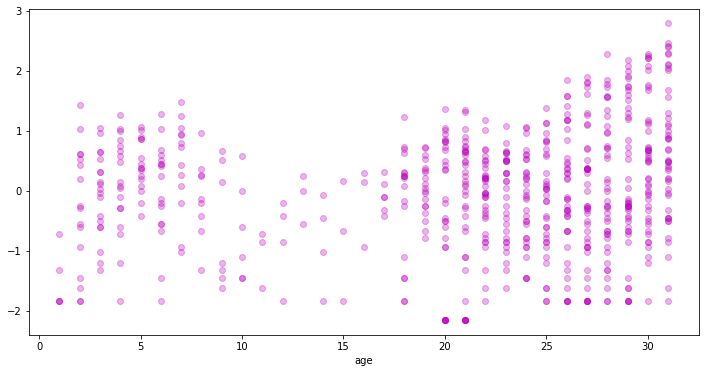

In [163]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.scatter(age_data, y_data["y"], color='m', alpha=0.3)
ax.scatter(age_data, engine_yhat, color="green", linewidth=1, alpha=0.5)

NameError: name 'engine_yhat' is not defined

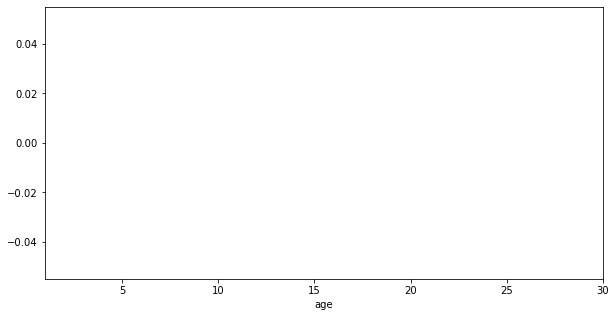

In [162]:
for ship in range(ship_count):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlabel('age')
    ax.set_xlim(1, 30)
    ax.scatter(age_data["age"].values[ship_data["ship"].values == ship], y_data["y"].values[ship_data["ship"].values == ship], color='m', alpha=0.3)
    ax.scatter(age_data["age"].values[ship_data["ship"].values == ship], engine_yhat[ship_data["ship"].values == ship], color="green", linewidth=1, alpha=0.5)

# Model 2. Use shipsize instead of engine

In [ ]:
shipsize_model = CmdStanModel(stan_file=model_file) #compile_model(layer3_path)

In [ ]:
shipsize_model_data = {
    "K" : basis_df.shape[1],
    "N" : data_count,  # number of total values
    "T" : max_age,  # length of time of data(31)
    "S" : ship_count, # number of ship types(99)
    "E" : shipsize_count,  # number of unique SHIPS
    "age": age_data["age"].values.tolist(),
    "engine": ship_size_mapping_data["shipsize"].values.tolist(),  # ship size mapping
    "ship": ship_data["ship"].values.tolist(),  # ship type mapping
    "Y": y_data["y"].values.tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": data_count,
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [ ]:
%%time
shipsize_model_fit = shipsize_model.sample(chains=4, cores=4, data=shipsize_model_data, adapt_delta=0.8)

In [ ]:
shipsize_model_fit.diagnose()

In [ ]:
shipsize_yhat = np.mean(shipsize_model_fit.get_drawset(params=["y_new_pred"]), axis=0).values
shipsize_yhat.shape

In [ ]:
mean_squared_error(y_data["y"].values, shipsize_yhat)

In [ ]:
smape(y_data["y"].values, shipsize_yhat)

In [ ]:
np.mean(shipsize_model_fit.get_drawset(params=["s_a_bar", "s_w_bar", "s_a", "s_w"]))

s_a: gamma(5, 1) (mean=5, var=5)
s_w: gamma(5, 1)
s_a_bar: half-normal(0, 5)
s_w_bar: gamma(5, 1)
-> normal(0,1)보다 작은 편차값들이 산출됨
prior 범위 [0, 1]로 수정

s_a_bar    0.484128
s_w_bar    0.093164
s_a        0.154160
s_w        0.299137
dtype: float64

In [ ]:
fig, ax = plt.subplots(figsize=(12, 20))
ax.set_xlabel('age')
ax.scatter(age_data, y_data["y"], color='m', alpha=0.3)
ax.scatter(age_data, ship, color="green", linewidth=1, alpha=0.5)
xpoints = (age_data["age"].values, age_data["age"].values)
ypoints = (y_data["y"], stacked_yhat)
ax.plot(xpoints, ypoints, lw=0.5)

## check out arviz stuf

In [ ]:
engine_az_inference = az.from_cmdstanpy(engine_model_fit, posterior_predictive="y_new_pred", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

In [ ]:
shipsize_az_inference = az.from_cmdstanpy(shipsize_model_fit, posterior_predictive="y_new_pred", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

In [ ]:
az.loo(engine_az_inference, pointwise=True)

In [ ]:
az.loo(shipsize_az_inference, pointwise=True)

In [ ]:
comp = az.compare({"engine": engine_az_inference, "shipsize": shipsize_az_inference}, ic="loo")
comp

In [ ]:
stacked_yhat = np.dot(np.transpose(np.vstack([engine_yhat, shipsize_yhat])), comp.weight.values)

In [ ]:
mean_squared_error(y_data["y"].values, stacked_yhat)

In [ ]:
smape(stacked_yhat, y_data["y"].values)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.scatter(age_data, y_data["y"], color='m', alpha=0.3)
ax.scatter(age_data, stacked_yhat, color="green", linewidth=1, alpha=0.5)
xpoints = (age_data["age"].values, age_data["age"].values)
ypoints = (y_data["y"], stacked_yhat)
#ax.plot(xpoints, ypoints, lw=0.5)

In [ ]:
pd.set_option('display.max_rows', None)
np.std(shipsize_model_fit.get_drawset(params=["y_new_pred"]).values.flatten())

In [ ]:
ax = plt.gca()
pd.DataFrame({"observed":y_data["y"].values}).plot.kde(ax=ax)
pd.DataFrame({"fitted posterior predictive(engine)": engine_yhat}).plot.kde(ax=ax)
pd.DataFrame({"fitted posterior predictive(shipsize)": shipsize_yhat}).plot.kde(ax=ax)

## Inferential Calibration

In [ ]:
simul_ensemble_file = os.path.join('./models','simulate_ensemble.stan')
simulate_ensemble_model = pystan.StanModel(file=simul_ensemble_file)

In [ ]:
R = 1000
N = 1000
sample_k = 17;
simul_data = {
    "K": basis_df.shape[1],
    "N" : N,
    "N_obs" : y_data["y"].values.shape[0],
    "T" : 31,
    "B" : basis_df.values.tolist(),
    "K_i" : sample_k,
    "y_data": y_data["y"].values.tolist(),
}
simulate_ensemble_fit = simulate_ensemble_model.sampling(iter=R, algorithm="Fixed_param", chains=1, data=simul_data) #compile_model(layer3_path))

In [ ]:
simul_samples = {}
for key in ["s_a", "s_w", "s_a_bar", "s_w_bar", "mu_a_bar"]:
    simul_samples[key] = simulate_ensemble_fit.extract(pars=[f"{key}"])[f"{key}"]
simul_samples["y"] = simulate_ensemble_fit.extract(pars=["sim_y"])["sim_y"]

In [ ]:
sim_w_bar = simulate_ensemble_fit.extract(pars=["mu_w_bar"])["mu_w_bar"]
# R = number of iterations, N = number of samples per iterations
# extracted sample array would be of shape (R, N, (dim(V) if vector))
for x in range(sim_w_bar.shape[1]): 
    simul_samples[f"mu_w_bar[{x+1}]"] = sim_w_bar[:, x]

In [ ]:
for key, val in simul_samples.items():
    print(key, val.shape)

In [ ]:
inferential_params = ["y", "s_a", "s_w", "s_a_bar", "s_w_bar", "mu_a_bar"] + [f"mu_w_bar[{x+1}]" for x in range(sim_w_bar.shape[1])]


In [ ]:
inferential_params

## Fit simulated ensemble

In [ ]:
fit_ensemble_file = os.path.join('./models','fit_data.stan')
nfit_ensemble_model = pystan.StanModel(file=fit_ensemble_file)

In [ ]:
post_zscores = {x: [] for x in inferential_params}
post_contraction_scores = {x: [] for x in inferential_params}
processes = 6  # number of PHYSICAL cores on system for maximum performance
splitted_simul_samples = [{} for x in range(processes)]
for param in inferential_params:
    batches = np.array_split(simul_samples[param], processes)
    i = 0
    for s in splitted_simul_samples:
        s[param] = batches[i]
        i += 1

In [ ]:
%%time
extracted_params = ["s_a", "s_w", "s_a_bar", "s_w_bar", "mu_a_bar", "mu_w_bar"]
def fit_parallel(samples, process_index):
    post_mean_scores = {k: [] for k in samples.keys()}
    post_sd_scores = {k: [] for k in samples.keys()}
    for i in range(samples["y"].shape[0]):  # iterate over number of chains
        fit_sample_k = sample_k;
        
        fit_ensemble_data = {
            "K": basis_df.shape[1],
            "N" : N,
            "T" : 31,
            "B" : basis_df.values.tolist(),
            "K_i" : fit_sample_k,
            "y" : samples["y"][i].tolist(),  # use np.mean?
            "N_obs" : y_data["y"].values.shape[0],
            "y_obs": y_data["y"].values.tolist(),
        }
        
        fit_ensemble_fit = nfit_ensemble_model.sampling(data=fit_ensemble_data, chains=1, iter=2000, n_jobs=1)
        summary_data = fit_ensemble_fit.summary(pars=extracted_params)["summary"]
        for index, param in enumerate([x for x in inferential_params if x != "y"]):
            post_mean_scores[param].append(summary_data[index][0])
            post_sd_scores[param].append(summary_data[index][2])
            
        post_y_samples = fit_ensemble_fit.extract(pars=["post_y"])["post_y"].flatten()
        post_mean_scores["y"].append(np.mean(post_y_samples))
        post_sd_scores["y"].append(np.std(post_y_samples))

    return (post_mean_scores, post_sd_scores, process_index)

pooled_post_mean_scores = {x: [] for x in inferential_params}
pooled_post_sd_scores = {x: [] for x in inferential_params}
process_results = []
import multiprocessing
with multiprocessing.Pool(processes=processes) as pool:
    results = [pool.apply_async(fit_parallel, (batch, index)) for  index, batch in enumerate(splitted_simul_samples)]
    
    for r in results:
        payload = r.get()
        process_results.append(payload)

In [ ]:
process_results = sorted(process_results, key=lambda x: x[2])
for param in inferential_params:
    for x in range(processes):
        pooled_post_mean_scores[param].extend(process_results[x][0][param])
        pooled_post_sd_scores[param].extend(process_results[x][1][param])

    pooled_post_mean_scores[param] = np.array(pooled_post_mean_scores[param])
    pooled_post_sd_scores[param] = np.array(pooled_post_sd_scores[param])

In [ ]:
zscore=0
# fig, ax = plt.subplots(len(inferential_params), figsize=(15,100))
for i, param in enumerate(inferential_params):
    if param == "y":
        continue
    prior_sd = np.std(simul_s3amples[param], ddof=1)
    zscore = (pooled_post_mean_scores[param] - simul_samples[param]) / pooled_post_sd_scores[param]
    contraction = 1 - (pooled_post_sd_scores[param] / prior_sd) ** 2
#     ax[i].set_title(param)
#     ax[i].set_xlim(0, 1)
#     ax[i].set_ylim(-50, 50)
#     ax[i].axhline(0, linestyle="--", c="black")
#     ax[i].set_xlabel("posterior contraction")
#     ax[i].set_ylabel("posterior z-score")
#     ax[i].scatter(contraction, zscore, c="r")`

In [ ]:
zscore

## Verdict: Poorly identified

The likelihood functions tend to disperse over expansive regions of the model configuration space for most, if not all, observations.

In [ ]:
fit_ensemble_data = {
            "K": basis_df.shape[1],
            "N" : 1000,
            "T" : 31,
            "B" : basis_df.values.tolist(),
            "K_i" : 15,
            "y" : simul_samples["y"][500].tolist(),  # use np.mean?
            "N_obs" : y_data["y"].values.shape[0],
            "y_obs": y_data["y"].values.tolist(),
        }
        
fit_ensemble_fit = nfit_ensemble_model.sampling(data=fit_ensemble_data, chains=4, iter=2000)

In [ ]:
ifd = az.from_pystan(posterior=fit_ensemble_fit, posterior_predictive="post_y", observed_data="y_obs")

In [ ]:
az.plot_ppc(ifd, data_pairs={"y_obs": "post_y"})